# Models of Axon game scores

Can accounting for individual player scores lead to a better model? Which matters more, learning rate (trait), number of plays (persistence), or some other factors?

## Summary

**background**: The original paper by Stafford and Dewar considered changes in play no. vs. average score in percentile groups of 5. As well, there was no explicit model(s) in the sense to be described. Can the need for grouping players beforehand be removed (such as by initial score, maximum score, or those who scored between X and Y, and so on, as seen in their original paper and in response to comments)?

**method**: Chose a cutoff of 5-15 plays because median scores still appear increasing in this range. There seems to be enough data, or player interest. Sampled down to n ~= 3000 players (~3%) for speed.

models: 

<pre>
"root": s = c +a N^r # higher r, faster (N >= 0; 0 &lt;= r &lt;= 1)
"log": s = c +a log_{1/r} N # higher r, faster (N >= 1; 0 &lt;= r &lt;= 1)

\mu_a ~ Normal(1, 0.1)
\sigma_a ~ HalfNormal(0.1)
\mu_r ~ Normal(0.5, 0.2)
\sigma_r ~ HalfNormal(0.1)

a ~ Normal(\mu_a, \sigma_a^2)
r ~ Normal(\mu_r, \sigma_r^2)

e ~ HalfCauchy(0.1)

L = StudentT(observed scores, nu=1, mu={model s}, sd=e)
</pre>

Each model's liklihood is fit with a StudentT(1) to better handle outliers.

The pooled mode fits one model for all players in aggregate. The hierarchical mode fits one model per player, but has shared hyperparameters on the variables above. The "%" model looks at the rate of change in scores per play, while the "abs" model looks at absolute scores. Only the latter is fit with $c$, but all errors are evaluated using the non-derivative model.

**result**:
<pre>
|              |      |  aad |      |
|              |      |  med |  iqr |
|--------------+------+------+------|
| pooled (1)   | root | 134% |  98% |
| hier %       | root |  54% | 106% |
|              | log  |  63% |  85% |
| hier abs (2) | root |  68% |  40% |
</pre>
aad: average absolute difference on fitted data. (1) same error rates in validation set, (2) uses aapd instead.

Learning rate (root) $r=0.3\pm0.029$, (log) $r=0.33\pm0.075$.

Initial score vs. median percent improvement: There is a moderate negative correlation (r=-0.36, p~=0), though two distinct groups appear. Though how points are assigned is unclear, perhaps some players had initial trouble with the rules, and thus it was not a genuine play. Nonetheless, initial scores are widely distributed, as is median improvement (~0-1).

**discussion**: From the play no. vs. score plot, though the median score increases with time, suggesting on average players do learn, the wide range in scores per play suggests, along with the large fitted errors `aad`, that this relation is rather weak, and performance is not always increasing, even if some posited latent ability may be.

The large fitted errors mean that the two models are indistinguishable, and thus it cannot be concluded whether performance is independent of the number of trials, independent of learning rate (if one compares the multiple of s where N \to kN), or some other factor holds.  However, the hierarchical model seems to have a better fit, implying that accounting for individual player variances can improve the overall model, and to confirm that players vary in terms of initial performance, and improvement.

As to whether grouping of players beforehand can be avoided, though improved with a hierarchical model, player variance, noise, and sheer amount of data places limits on such an approach.

**future**: Perhaps conditioning rate of improvement on initial performance might distinguish better cases of low/high starting points from low/high learning rates.

Still need to run a posterior predictive check, as well as a better way to compare the models (ie. not just by fitted error alone).


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats
import seaborn
from IPython.core.display import display

import datetime
import json
import pymc3 as pm

np.random.seed(0)

In [2]:
## tabularize
filename_data = "data_by_cookie.json"

def _f(row):
    score = date_int = hour = dt = None
    try:
        score = row[0]
        date_int = row[1]
        hour = row[2]
    except:
        pass
    try:
        dt = datetime.datetime.combine(
            datetime.datetime.strptime(str(date_int), '%Y%m%d'),
            datetime.time(hour))
    except:
        pass
    return score, dt

acc = []
acc_id = {} # replace id with smaller id value
id_idx = 0
with open(filename_data, 'r') as infile:
    raw_data = json.load(infile)
    for player, plays in raw_data.items():
        if player in acc_id:
            player_id = acc_id[player]
        else:
            player_id = id_idx
            acc_id[player] = player_id
            id_idx += 1            
        for play_num, row in plays.items():
            score, dt = _f(row)
            acc.append([player_id, int(play_num) -1, score, dt]) # use idx-0
del raw_data
del acc_id # don't keep for now
df_raw = pd.DataFrame(acc, columns=['player', 'play_num', 'score', 'dt'])

In [3]:
df_raw.sort_values(['player', 'play_num'], inplace=True)


In [4]:
display(len(df_raw['player'].unique()))
display(df_raw.head(), df_raw.shape)

854064

,player,play_num,score,dt
1,0,0,176,2012-04-17 15:00:00
2,0,1,176,2012-04-17 15:00:00
4,0,2,176,2012-04-17 15:00:00
3,0,3,6499,2012-04-17 15:00:00
0,0,4,48522,2012-04-17 15:00:00


(3099705, 4)

## raw data inspect

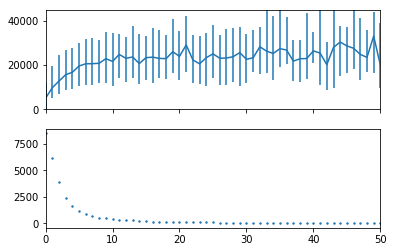

In [5]:
p = 0.01
df = df_raw.sample(frac=p, axis=0)[['play_num', 'score']]
df_d = df.groupby('play_num')['score'].describe()
# display(df_d.head())

fig, axs = plt.subplots(2,1, sharex=True)
ax = axs[0]
xs = df_d.index
ys = df_d['50%']
ax.errorbar(xs, ys, yerr=[ys -df_d['25%'], df_d['75%'] -ys])
ax.set_xlim([0, 50])
ax.set_ylim([0, np.percentile(ys, 90)])

ax = axs[1]
ax.scatter(xs, df_d['count'], s=2)

# ax = seaborn.tsplot(data=df, unit='player', value='score', time='play_num', estimator=np.nanmedian, ci=[68, 95]) # nanmean otherwise even a single NaN will cause it to not plot


Scores too varied starting at ~30, but for enough samples, cutoff at 5 to 15.

## filter and pre-process data

In [6]:
invalid_score_players = df_raw[df_raw['score'].isnull()]['player']

df_player_num_plays = df_raw.groupby('player')['play_num'].aggregate([len, max])
df_player_num_plays.columns = ['num_plays', 'max_plays']
invalid_play_record_players = df_player_num_plays[(df_player_num_plays['num_plays'] -1 != df_player_num_plays['max_plays'])].index # has missing play records

## exclude due to memory and speed of inference
MIN_NUM_PLAYS = 5
MAX_NUM_PLAYS = 15
cond = (df_player_num_plays['num_plays'] <= MIN_NUM_PLAYS)
# cond_2 = (df_player_num_plays['num_plays'] > MAX_NUM_PLAYS)
players_num_plays_range = df_player_num_plays[cond].index

invalid_players = set(invalid_score_players).union(invalid_play_record_players).union(players_num_plays_range)

In [7]:
display(len(invalid_players))
display(df_player_num_plays.describe())

744401

,num_plays,max_plays
count,854064.000000,854064.000000
mean,3.629359,2.729115
std,6.764446,7.320048
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,4.000000,3.000000
max,1329.000000,1380.000000


(0, 20)

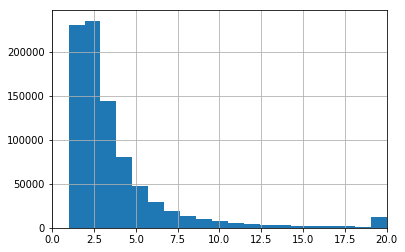

In [8]:
ax = df_player_num_plays['num_plays'].map(lambda x: 20 if x >= 20 else x).hist(bins=20)
ax.set_xlim([0, 20])

In [9]:
cond = (~df_raw['player'].isin(invalid_players))
df_input = df_raw[cond]

## downsample players
p = 0.03
selected_players = np.random.choice(
    df_input['player'].unique(), 
    size=int(p*len(df_input['player'].unique())), 
    replace=False)
cond = (df_input['player'].isin(selected_players))
selected_players_valid = np.random.choice(
    df_input[~cond]['player'].unique(), 
    size=int(p*len(df_input[~cond]['player'].unique())), 
    replace=False)
cond_valid = (df_input['player'].isin(selected_players_valid))

df_input_valid = df_input[cond_valid]
df_input = df_input[cond]


## re-index players
vals = df_input['player'].unique()
idxs = range(0, len(vals))
idxmap = dict(zip(vals, idxs))

df_input['player'] = df_input['player'].map(idxmap.get)

In [10]:
## start binary
def _calc_player_scores_percent_change(df_input):
    df_play_scores = df_input.pivot_table(values='score', index='player', columns='play_num')
    df_play_scores_pct_change = df_play_scores.pct_change(axis=1) # column N means N / N-1

    df_2 = df_play_scores_pct_change[df_play_scores_pct_change.columns[:MAX_NUM_PLAYS]] # truncate for now
    df_player_scores_percent_change = pd.melt(df_2[df_2.columns[1:]].reset_index(), id_vars='player').sort_values(['player', 'play_num']).dropna()
    # df_m.head()
    df_player_scores_percent_change.columns = ['player', 'play_num', 'change']
    return df_player_scores_percent_change
df_player_scores_percent_change = _calc_player_scores_percent_change(df_input)
df_player_scores_percent_change_valid = _calc_player_scores_percent_change(df_input_valid)

display(df_player_scores_percent_change['player'].unique().shape)
display(df_player_scores_percent_change_valid['player'].unique().shape)
display(df_player_scores_percent_change.head(), df_player_scores_percent_change.shape)
display(df_player_scores_percent_change_valid.head(), df_player_scores_percent_change_valid.shape)

(3289,)

(3191,)

,player,play_num,change
0,0,1,3.360784
3289,0,2,-0.770683
6578,0,3,72.984314
9867,0,4,-0.022368
13156,0,5,0.756886


(27495, 3)

,player,play_num,change
0,318,1,-0.433395
3191,318,2,-0.598818
6382,318,3,2.407552
9573,318,4,-0.579988
12764,318,5,-0.362711


(26316, 3)

## initial score vs. percent improvement

In [11]:
## any correlation between initial score and subsequent percent improvement?

def _calc_median_change(df_input, df_player_scores_percent_change):
    df_input_player_median_change = df_player_scores_percent_change.groupby('player')[['change']].median()
    df_input_player_median_change.columns = ['median_change']

    df = pd.merge(
        df_input[['player', 'play_num', 'score']],
        df_input_player_median_change.reset_index(),
        on='player',
        how='left',
    )
    return df

df = _calc_median_change(df_input, df_player_scores_percent_change)
df_valid = _calc_median_change(df_input_valid, df_player_scores_percent_change_valid)

cond = (df['play_num'] == 0)
df = df[cond]
cond = (df_valid['play_num'] == 0)
df_valid = df_valid[cond]
display(df.head(), df_valid.head())

,player,play_num,score,median_change
0,0,0,255,0.756886
6,1,0,176,-0.049195
19,2,0,50461,0.068661
50,3,0,15590,0.293619
58,4,0,176,0.785251


,player,play_num,score,median_change
0,318,0,28076,-0.433395
8,605,0,534,0.194612
17,620,0,176,0.833215
25,1007,0,14729,-0.118735
31,1224,0,176,0.215721


(-0.5, 2)

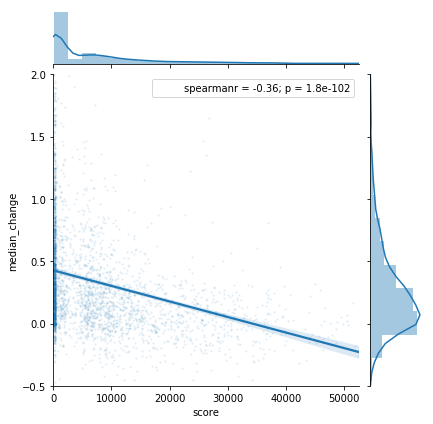

In [12]:
g = seaborn.jointplot(data=df, x='score', y='median_change', kind='reg', scatter_kws={'alpha': 0.08, 's': 2}, stat_func=scipy.stats.spearmanr)
g.ax_joint.set_xlim([0, np.percentile(df['score'], 99)])
g.ax_joint.set_ylim([-0.5, 2])

(-0.5, 2)

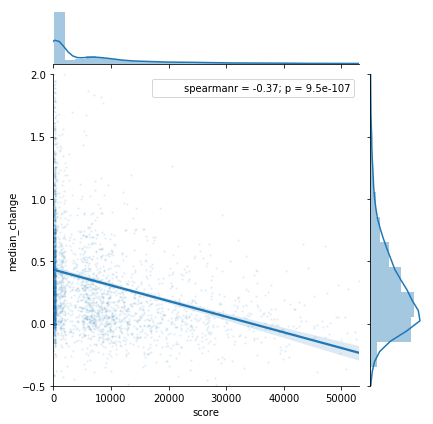

In [13]:
g = seaborn.jointplot(data=df_valid, x='score', y='median_change', kind='reg', scatter_kws={'alpha': 0.08, 's': 2}, stat_func=scipy.stats.spearmanr)
g.ax_joint.set_xlim([0, np.percentile(df_valid['score'], 99)])
g.ax_joint.set_ylim([-0.5, 2])

## pooled model

In [14]:
n_players = max(df_player_scores_percent_change['player']) +1 # idx-0
idxs_players = df_player_scores_percent_change['player'].values.astype(np.int) # .values required otherwise in the regression line, will throw a "invalid type comparison"
play_nums = df_player_scores_percent_change['play_num'].values.astype(np.int)
player_score_rates = df_player_scores_percent_change['change'].values

In [15]:
with pm.Model() as pooled_root_model:
    a = pm.Normal('a', mu=1, sd=0.1)
    bound_n = pm.Bound(pm.Normal, lower=0, upper=1)
    r = bound_n('r', mu=0.5, sd=0.2)
    
    term = (r -1)
    rate_est = a * (term +1) * (play_nums ** term)

    bound_e = pm.Bound(pm.HalfCauchy, lower=0.01) # bound so to avoid bad initial energy inf in case of sd=0?
    eps_model = bound_e('eps_model', beta=0.1)

    # pm.StudentT
    rate_like = pm.StudentT('rate_like', nu=1, mu=rate_est, sd=eps_model, observed=player_score_rates) # places more weight in the tails
#    rate_like = pm.Normal('rate_like', mu=rate_est, sd=eps_model, observed=player_score_rates)

In [16]:
with pooled_root_model:
    pooled_root_trace = pm.sample(draws=500, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 997/1000 [00:19<00:00, 50.45it/s]/home/wleung/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.892660732304, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:19<00:00, 50.46it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f753a006588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f751ebcac88>]], dtype=object)

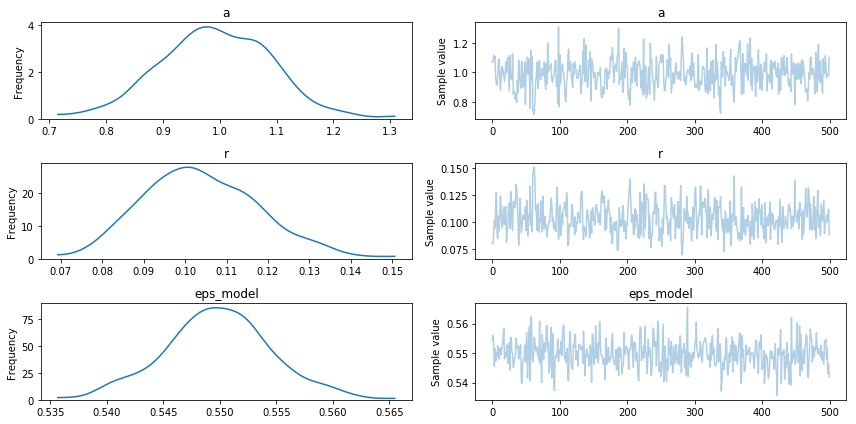

In [17]:
pm.traceplot(pooled_root_trace)

### model fit

In [18]:
a = pooled_root_trace['a'][-1]
r = pooled_root_trace['r'][-1]

ser_value_pred = a * (play_nums ** r)
ser_value_pred_valid = a * (df_player_scores_percent_change_valid['play_num'].values.astype(np.int) ** r)

# RMSD (root mean square deviation)
rmsd = np.sqrt(
    sum((ser_value_pred -player_score_rates)**2) / len(player_score_rates))

# average absolute difference
ser = pd.Series(np.abs(
        ser_value_pred -player_score_rates
    ))
display(ser.describe())
aad = np.mean(ser)
display(rmsd, aad)

ser = pd.Series(np.abs(ser_value_pred_valid -df_player_scores_percent_change_valid['change'].values))
display(ser.describe())
aad_valid = np.mean(ser)
display(aad_valid)

count    27495.000000
mean         4.409509
std         16.833913
min          0.000020
25%          0.844073
50%          1.340335
75%          1.820215
max        480.455411
dtype: float64

17.401554337459437

4.4095089688200897

count    26316.000000
mean         4.506166
std         16.579016
min          0.000033
25%          0.846325
50%          1.343564
75%          1.822641
max        491.463853
dtype: float64

4.5061658702890677

Negative correlation means those with high starting scores have less improvement.

## hierarchical model (%improvement)

In [19]:
with pm.Model() as hierarchical_root_model:
    mu_a = pm.Normal('mu_a', mu=1, sd=0.1)
    sigma_a = pm.HalfNormal('sigma_a', sd=0.1) # unsure how to set this
    mu_r = pm.Normal('mu_r', mu=0.5, sd=0.2)
    sigma_r = pm.HalfNormal('sigma_r', sd=0.1)
    
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_players)
    bound_n = pm.Bound(pm.Normal, lower=0, upper=1)
    r = bound_n('r', mu=mu_r, sd=sigma_r, shape=n_players)
    
    term = (r[idxs_players] -1)
    rate_est = a[idxs_players] * (term +1) * (play_nums ** term)

    bound_e = pm.Bound(pm.HalfCauchy, lower=0.01) # bound so to avoid bad initial energy inf in case of sd=0?
    eps_model = bound_e('eps_model', beta=0.1)
    # eps_model = pm.HalfNormal('eps_model', sd=0.1)
    
    rate_like = pm.StudentT('rate_like', nu=1, mu=rate_est, sd=eps_model, observed=player_score_rates) # more robust than Normal
#    rate_like = pm.Normal('rate_like', mu=rate_est, sd=eps_model, observed=player_score_rates)

In [20]:
with pm.Model() as hierarchical_log_model:
    mu_a = pm.Normal('mu_a', mu=1, sd=0.1)
    sigma_a = pm.HalfNormal('sigma_a', sd=0.1) # unsure how to set this
    mu_r = pm.Normal('mu_r', mu=0.5, sd=0.2)
    sigma_r = pm.HalfNormal('sigma_r', sd=0.1)
    
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_players)
    bound_n = pm.Bound(pm.Normal, lower=0, upper=1)
    r = bound_n('r', mu=mu_r, sd=sigma_r, shape=n_players)
    
    rate_est = -1 * a[idxs_players] / (play_nums * np.log(r[idxs_players]))

    bound_e = pm.Bound(pm.HalfCauchy, lower=0.01) # bound so to avoid bad initial energy inf in case of sd=0?
    eps_model = bound_e('eps_model', beta=0.1)
    # eps_model = pm.HalfNormal('eps_model', sd=0.1)

    rate_like = pm.StudentT('rate_like', nu=1, mu=rate_est, sd=eps_model, observed=player_score_rates) # more robust than Normal
#    rate_like = pm.Normal('rate_like', mu=rate_est, sd=eps_model, observed=player_score_rates)

In [21]:
with hierarchical_root_model:
    hierarchical_root_trace = pm.sample(draws=500, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]/home/wleung/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:437: UserWarning: Chain 0 contains only diverging samples. The model is probably misspecified.
  % self._chain_id)
/home/wleung/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.131848373285, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/wleung/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 500 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



In [22]:
with hierarchical_log_model:
    hierarchical_log_trace = pm.sample(draws=500, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 999/1000 [03:07<00:00,  5.34it/s]/home/wleung/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.567978128154, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/wleung/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7515878160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f75397ed1d0>]], dtype=object)

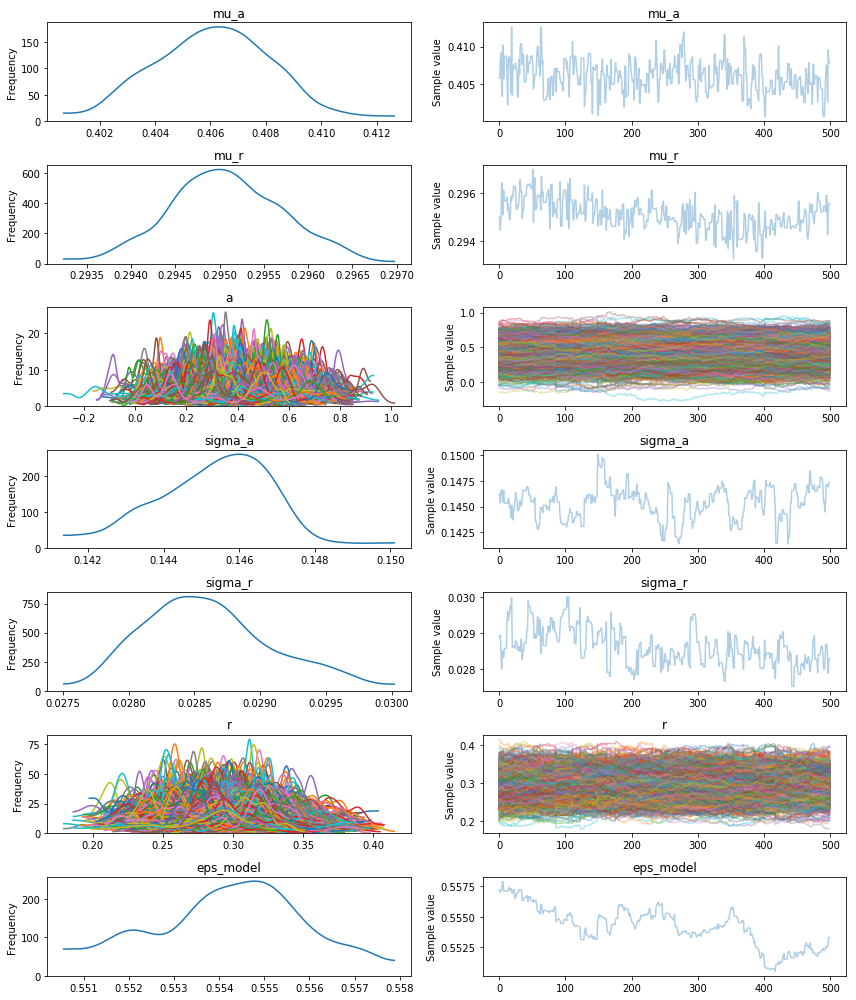

In [23]:
pm.traceplot(hierarchical_root_trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f752fd14390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f752f015b70>]], dtype=object)

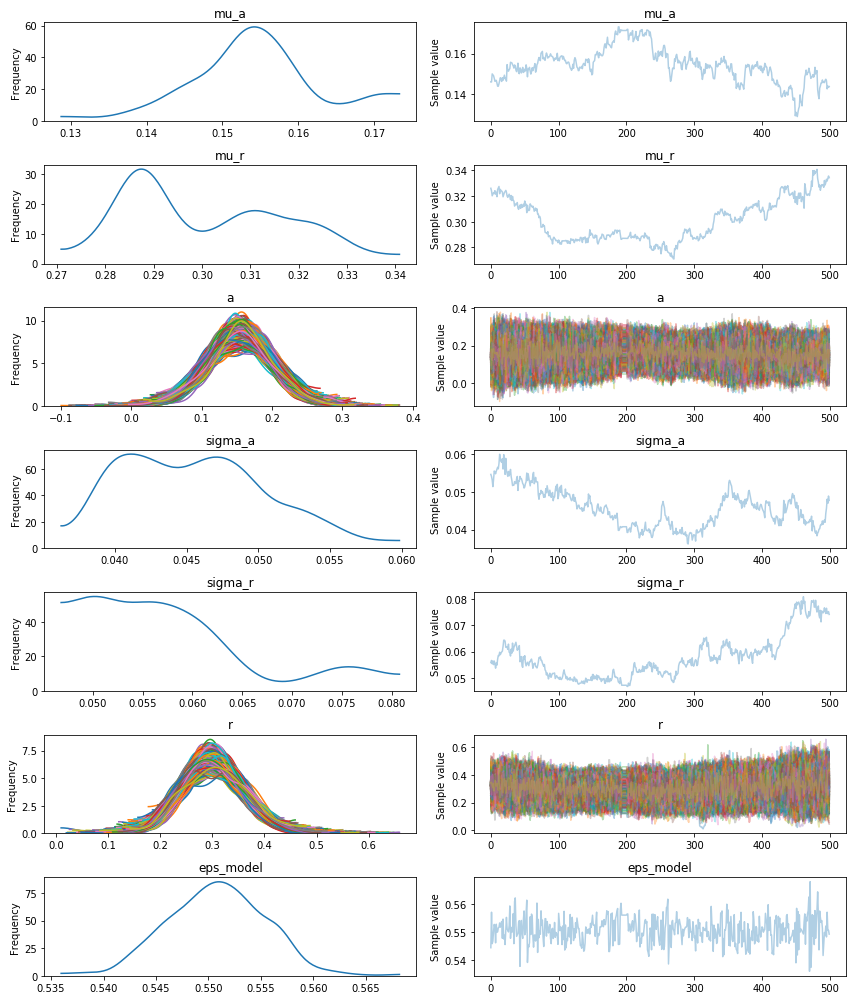

In [24]:
pm.traceplot(hierarchical_log_trace)

### model fit

In [25]:
as_ = hierarchical_root_trace['a'][-1, :]
rs = hierarchical_root_trace['r'][-1, :]
# droping a
df_params_root = pd.DataFrame(list(zip(as_, rs)), columns=['a', 'r'])
df_params_root.index.name = 'player'

df_player_scores_percent_change_params_root = df_player_scores_percent_change[['player', 'play_num', 'change']].join(df_params_root.reset_index(), on='player', rsuffix=('_r'))
def _f(ser):
    term = (ser['r'] -1)
    return ser['a'] * term * (ser['play_num'] ** term)
df_player_scores_percent_change_params_root['change_pred'] = df_player_scores_percent_change_params_root.apply(_f, axis=1)

df_player_scores_percent_change_params_root_valid = df_player_scores_percent_change_valid[['player', 'play_num', 'change']].join(df_params_root.reset_index(), on='player', rsuffix=('_r'))
def _f(ser):
    term = (ser['r'] -1)
    return ser['a'] * term * (ser['play_num'] ** term)
df_player_scores_percent_change_params_root['change_pred'] = df_player_scores_percent_change_params_root.apply(_f, axis=1)


In [26]:
display(df_params_root.describe())

,a,r
count,3289.000000,3289.000000
mean,0.404571,0.295034
std,0.146603,0.028503
min,-0.132179,0.179891
25%,0.303538,0.275641
50%,0.402327,0.295508
75%,0.501936,0.313874
max,0.885061,0.397625


In [27]:
# RMSD (root mean square deviation)
rmsd_root = np.sqrt(
    sum((df_player_scores_percent_change_params_root['change_pred'] -df_player_scores_percent_change_params_root['change'])**2) / len(df_player_scores_percent_change_params_root['change']))

# average absolute difference
ser = np.abs(
        df_player_scores_percent_change_params_root['change_pred'] -df_player_scores_percent_change_params_root['change']
    )
display(ser.describe())
aad_root = np.mean(ser)
display(rmsd_root, aad_root)

count    27495.000000
mean         4.122382
std         17.161471
min          0.000004
25%          0.245070
50%          0.540576
75%          1.306092
max        481.856240
dtype: float64

17.649346141845744

4.1223815309679699

In [28]:
as_ = hierarchical_log_trace['a'][-1, :]
rs = hierarchical_log_trace['r'][-1, :]
# droping a
df_params_log = pd.DataFrame(list(zip(as_, rs)), columns=['a', 'r'])
df_params_log.index.name = 'player'


df_player_scores_percent_change_params_log = df_player_scores_percent_change[['player', 'play_num', 'change']].join(df_params_log.reset_index(), on='player', rsuffix=('_r'))
def _f(ser):
    return ser['a'] * np.log(ser['play_num']) / np.log(1/ser['r'])
df_player_scores_percent_change_params_log['change_pred'] = df_player_scores_percent_change_params_log.apply(_f, axis=1)

In [29]:
display(df_params_log.describe())

,a,r
count,3289.000000,3289.000000
mean,0.144398,0.334534
std,0.047852,0.075266
min,-0.015880,0.044218
25%,0.111121,0.284429
50%,0.146270,0.335449
75%,0.176408,0.385667
max,0.301199,0.582963


In [30]:
# RMSD (root mean square deviation)
rmsd_log = np.sqrt(
    sum((df_player_scores_percent_change_params_log['change_pred'] -df_player_scores_percent_change_params_log['change'])**2) / len(df_player_scores_percent_change_params_log['change']))

# average absolute difference
ser = np.abs(
        df_player_scores_percent_change_params_log['change_pred'] -df_player_scores_percent_change_params_log['change']
    )
display(ser.describe())
aad_log = np.mean(ser)
display(rmsd_log, aad_log)

count    27495.000000
mean         4.082837
std         17.108368
min          0.000000
25%          0.291047
50%          0.634137
75%          1.140408
max        481.528635
dtype: float64

17.588494941585985

4.0828371108179562

## hierarchical model (absolute scores)

count     3250.000000
mean      7188.831692
std       9726.382257
min        176.000000
25%        226.000000
50%       2320.000000
75%      10304.500000
max      49914.000000
Name: score, dtype: float64

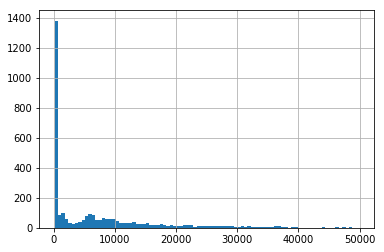

In [31]:
## get initial c (this might be cheating)
cond = (df_input['play_num'] == 0)
cond_2 = (df_input['score'] <= 1e5/2)
df_input[cond & cond_2]['score'].hist(bins=90)
d = df_input[cond & cond_2]['score'].describe()
display(d)

In [32]:
#n_players = len(df_input['player'].unique())
n_players_input = max(df_input['player']) +1 # idx-0
idxs_player_input = df_input['player'].values # .values required otherwise in the regression line, will throw a "invalid type comparison"
play_nums_input = df_input['play_num'].values
player_scores_input = df_input['score'].values

In [33]:
with pm.Model() as hierarchical_root_absolute_model:
    mu_c = pm.Normal('mu_c', mu=d['mean'], sd=d['std'])
    sigma_c = pm.HalfCauchy('sigma_c', beta=d['std']) # unsure how to set this
    mu_r = pm.Normal('mu_r', mu=0.5, sd=0.2)
    sigma_r = pm.HalfNormal('sigma_r', sd=0.1)

    c = pm.Normal('c', mu=mu_c, sd=sigma_c, shape=n_players_input)
    e = 0.0000
    bound_n = pm.Bound(pm.Normal, lower=0+e, upper=1-e)
    r = bound_n('r', mu=mu_r, sd=sigma_r, shape=n_players_input) # Uniform too wide
    a = pm.Normal('a', mu=1, sd=0.1, shape=n_players_input) # unsure about the constant
    
    eps_model = pm.HalfCauchy('eps_model', beta=d['std']) # model error; unsure if I should use d
    
    score_est = c[idxs_player_input] + a[idxs_player_input] * (play_nums_input ** r[idxs_player_input])

#    score_like = pm.Normal('score_like', mu=score_est, sd=eps_model, observed=player_scores)
    score_like = pm.StudentT('score_like', nu=1, mu=score_est, sd=eps_model, observed=player_scores_input)

In [34]:
with hierarchical_root_absolute_model:
    hierarchical_root_absolute_trace = pm.sample(draws=500, n_init=1000) # why such a big difference in time (from 9.5h to 1.5h ... but it ballooned to 4h and counting...) if from 2000 to 500 draws, at 34k players?
    # now with ~1k players (draws=500), much faster
    # 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [07:54<00:00,  2.11it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74c6dfe3c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f74c6a5d198>]], dtype=object)

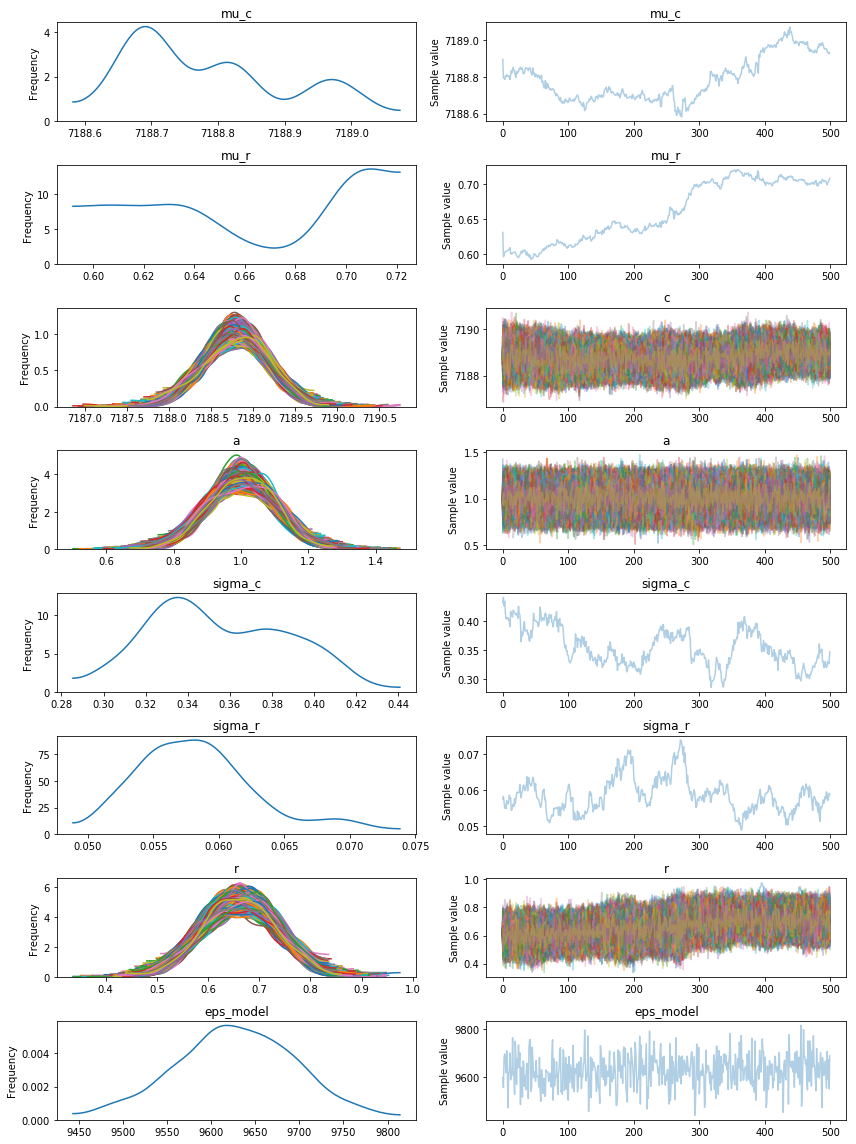

In [35]:
pm.traceplot(hierarchical_root_absolute_trace)

In [36]:
as_ = hierarchical_root_absolute_trace['a'][-1, :]
cs = hierarchical_root_absolute_trace['c'][-1, :]
rs = hierarchical_root_absolute_trace['r'][-1, :]
# droping a
df_params_root_absolute = pd.DataFrame(list(zip(as_, cs, rs)), columns=['a', 'c', 'r'])
df_params_root_absolute.index.name = 'player'


df_input_params_root_absolute = df_input[['player', 'play_num', 'score']].join(df_params_root_absolute.reset_index(), on='player', rsuffix=('_r'))
def _f(ser):
    return ser['c'] +ser['a'] * (ser['play_num'] ** ser['r'])
df_input_params_root_absolute['score_pred'] = df_input_params_root_absolute.apply(_f, axis=1)


In [37]:
df_params_root_absolute.describe()

,a,c,r
count,3289.000000,3289.000000,3289.000000
mean,0.997272,7188.933666,0.708167
std,0.097836,0.340561,0.058978
min,0.646970,7187.872727,0.498418
25%,0.928483,7188.704692,0.669939
50%,0.995685,7188.939223,0.708408
75%,1.062115,7189.172928,0.748174
max,1.318514,7190.026112,0.941577


In [38]:
# RMSD (root mean square deviation)
rmsd_root_abs = np.sqrt(
    sum((df_input_params_root_absolute['score_pred'] -df_input_params_root_absolute['score'])**2) / len(df_input_params_root_absolute['score']))
# average absolute percentage difference
ser = np.abs((df_input_params_root_absolute['score_pred'] / df_input_params_root_absolute['score']) -1)
display(ser.describe())
aapd_root_abs = np.mean(ser)
display(rmsd_root_abs, aapd_root_abs)


count    37512.000000
mean         2.865109
std          8.290096
min          0.000078
25%          0.413925
50%          0.682232
75%          0.816388
max         39.972818
dtype: float64

23821.56872726548

2.8651091734309468